# Goal #
To create a model to predict resale prices of HDB flats

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

## Data ##
Data was obtained from government website https://beta.data.gov.sg/. I used two different data sets and merged them to increase the number of features that the dataset has, to improve the model's performance.

In [401]:
hdb_resale_df = pd.read_csv(r'C:\Users\USER\Documents\Projects\Singapore Housing Resale Price\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
property_info_df = pd.read_csv(r'C:\Users\USER\Documents\Projects\Singapore Housing Resale Price\HDBPropertyInformation.csv')
hdb_resale_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [402]:
property_info_df.head()

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,138,1,2,0,0,0,0,0,0,0
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,204,0,2,0,0,0,0,0,0,0
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,0,0,0,0
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,10,92,0,0,0,0,0,0,0
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,54,0,1,0,0,0,0,0,0,0


I will merge the data based on the street names and block numbers. However, before doing so, there is some miscellaneous data that is not needed in our model, such as the number of flats sold. I will remove these columns before mergeing the datasets.

In [403]:
dropped_property_info_df = property_info_df.drop(columns=['max_floor_lvl','bldg_contract_town','total_dwelling_units','1room_sold','2room_sold','3room_sold','4room_sold','5room_sold','exec_sold','multigen_sold','studio_apartment_sold','1room_rental',
                          '2room_rental','3room_rental','other_room_rental','residential','year_completed'])

In [404]:
merged_df = pd.merge(hdb_resale_df,dropped_property_info_df,left_on=['block','street_name'],right_on=['blk_no','street'])
## remove street names and block numbers as they are too specific
df = merged_df.drop(columns=['month','street_name','block','lease_commence_date','blk_no','street'])
df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion
0,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,61 years 04 months,232000.0,N,N,N,N,N
1,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,61 years 01 month,235000.0,N,N,N,N,N
2,ANG MO KIO,2 ROOM,01 TO 03,44.0,Improved,60 years 02 months,202000.0,N,N,N,N,N
3,ANG MO KIO,2 ROOM,01 TO 03,44.0,Improved,60 years 02 months,210000.0,N,N,N,N,N
4,ANG MO KIO,2 ROOM,07 TO 09,44.0,Improved,60 years 01 month,220000.0,N,N,N,N,N


## Exploratory Data Analysis ##
We shall now take a look in detail at the various features of our dataset. 

In [405]:
df.shape

(157681, 12)

There are 157,681 samples in the dataset, which is more than sufficient for this project.

In [406]:
df.isnull().sum()

town                   0
flat_type              0
storey_range           0
floor_area_sqm         0
flat_model             0
remaining_lease        0
resale_price           0
commercial             0
market_hawker          0
miscellaneous          0
multistorey_carpark    0
precinct_pavilion      0
dtype: int64

There is no missing data in this dataset, which is expected as the data comes from a database managed by the Singapore government.

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157681 entries, 0 to 157680
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 157681 non-null  object 
 1   flat_type            157681 non-null  object 
 2   storey_range         157681 non-null  object 
 3   floor_area_sqm       157681 non-null  float64
 4   flat_model           157681 non-null  object 
 5   remaining_lease      157681 non-null  object 
 6   resale_price         157681 non-null  float64
 7   commercial           157681 non-null  object 
 8   market_hawker        157681 non-null  object 
 9   miscellaneous        157681 non-null  object 
 10  multistorey_carpark  157681 non-null  object 
 11  precinct_pavilion    157681 non-null  object 
dtypes: float64(2), object(10)
memory usage: 14.4+ MB


Here we can see that most of our features are non-numerical. In Singapore, a longer remaining lease is more desirable. Hence, I will convert the values in the remaining lease column to a numerical one during the feature engineering step 

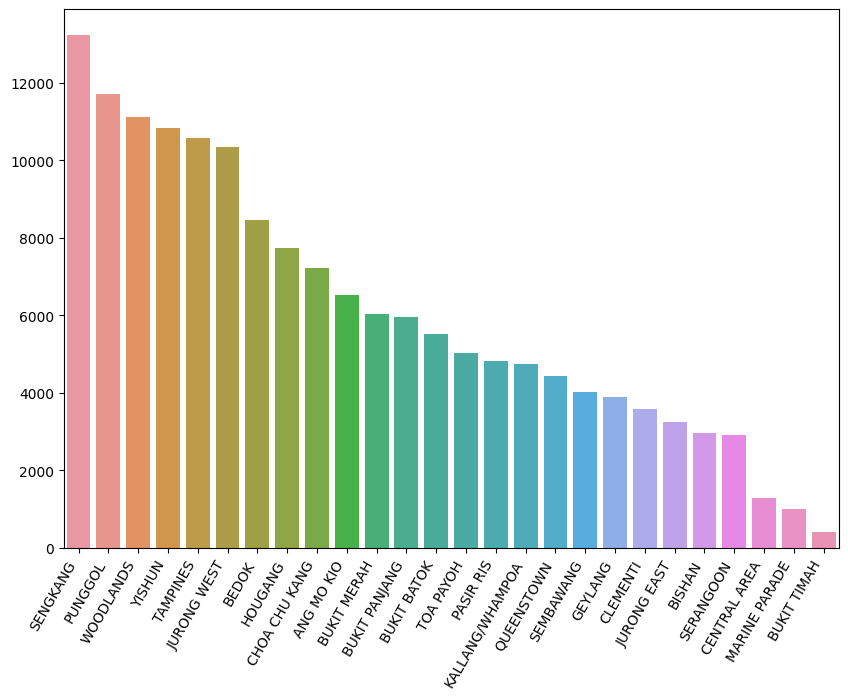

In [408]:
town_count = dict(df.town.value_counts())
plt.figure(figsize=(10,7))
town_plot = sns.barplot(x=list(town_count.keys()),y=list(town_count.values()))
town_plot.set_xticklabels(town_plot.get_xticklabels(), rotation=60, ha="right")
plt.show()


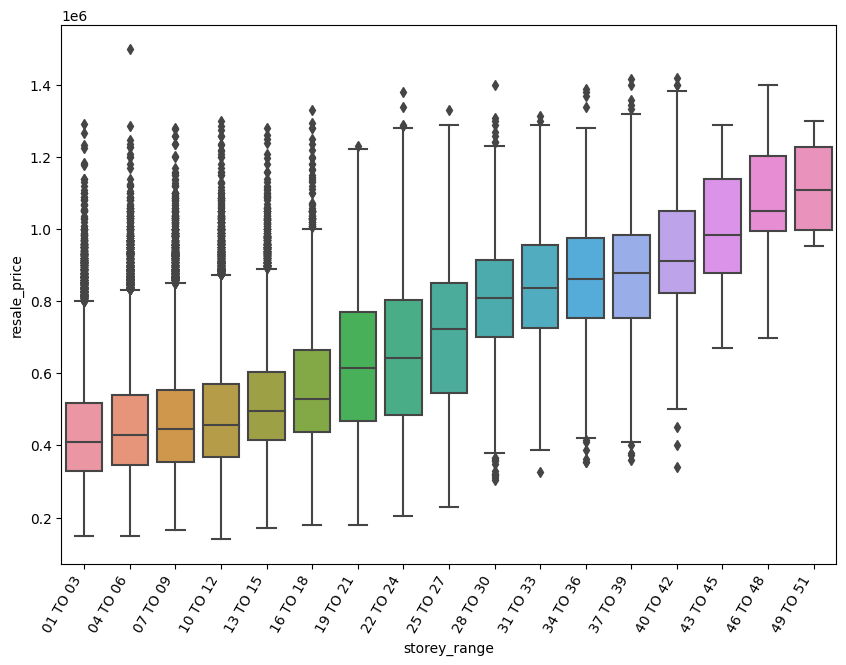

In [409]:
plt.figure(figsize=(10,7))
median_by_storey_range = df.groupby(['storey_range'])['resale_price'].median().sort_values(ascending=True)
storey_range_plot = sns.boxplot(data=df, x='storey_range', y='resale_price',order=median_by_storey_range.index)
storey_range_plot.set_xticklabels(storey_range_plot.get_xticklabels(), rotation=60, ha="right")
plt.show()

This boxplot shows a comparison between storey range and resale prices. Generally, we can see that the higher the storey, the higher the median resale price. This corroborates with my experience living in Singapore, where most people associate a higher storey with a higher price. We can thus apply ordinal encoding to this feature later.

In [410]:
floor_area_sqm_corr = df.corr(numeric_only=True)
floor_area_sqm_corr

,floor_area_sqm,resale_price
floor_area_sqm,1.000000,0.608192
resale_price,0.608192,1.000000


This correlation matrix shows a positive correlation between resale price and size of the flat.

## Feature Engineering ##
In Singapore, a longer lease usually increases the value of the resale price. I will thus convert the remaining lease into a float type (where 60.5 years = 60 years and 6 months left). I will then use one-hot encoder to encode the categorical features and ordinal encoding for the storey ranges.

In [411]:
def lease_to_float(str):
    split =str.split()
    return int(split[0]) + int(split[-2])/12

df.remaining_lease = df.remaining_lease.apply(lease_to_float)

In [412]:
df.storey_range = df.storey_range.apply(lambda x: ['01 TO 03','04 TO 06','07 TO 09','10 TO 12','13 TO 15','16 TO 18','19 TO 21','22 TO 24','25 TO 27','28 TO 30', '31 TO 33','34 TO 36','37 TO 39','40 TO 42','43 TO 45','46 TO 48','49 TO 51'].index(x))
df = pd.get_dummies(data=df,columns= ['town','flat_type','flat_model'], dtype=int)
for row in range(4,9):
    df.iloc[:,row] = df.iloc[:,row].apply(lambda x:['N','Y'].index(x))
    df[df.columns[row]] = df[df.columns[row]].astype('int32')
df.head()

,storey_range,floor_area_sqm,remaining_lease,resale_price,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,town_ANG MO KIO,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,3,44.0,61.333333,232000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,44.0,61.083333,235000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,44.0,60.166667,202000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,44.0,60.166667,210000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,44.0,60.083333,220000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [413]:
scaler = StandardScaler()
df[['floor_area_sqm','remaining_lease']] = scaler.fit_transform(df[['floor_area_sqm','remaining_lease']])

## Data Training ##
With the dataset ready, we shall now train a model to predict the resale price. First, we split the data into the test, validation, and training sets.

In [414]:
y = df.pop('resale_price')

In [415]:

resale_scaler = StandardScaler()
y = resale_scaler.fit_transform(y.to_numpy().reshape(-1,1))
X_train, X_val, y_train, y_val = train_test_split(df,y,test_size=0.3,random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size=0.5,random_state=2)

In [416]:
boost = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=30)
boost.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [417]:
preds = boost.predict(X_test).reshape(-1,1)
accuracy = mean_squared_error(resale_scaler.inverse_transform(y_test),resale_scaler.inverse_transform(preds),squared=False)
float(accuracy)

47897.0234155155